## Marketing Mix Model

Mix Model is simply a multiple linear regression model that predicts sales from marketing spend, and other factors. By identifying correlations between the marketing spend on a channel, or a specific type of marketing campaign, the model is able to identify its effectiveness at increasing sales, allowing different scenarios to be tested. It can tell you the optimal media mix to get improved sales from marketing efforts.


This project is based on the article posted by Matt Clarke.

Thank you so much for sharing this model!

Link to the original article:

https://practicaldatascience.co.uk/machine-learning/how-to-create-a-basic-marketing-mix-model-in-scikit-learn

In [1]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lars
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.svm import SVR
from sklearn.svm import NuSVR
from sklearn.svm import LinearSVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.isotonic import IsotonicRegression
from sklearn.ensemble import RandomForestRegressor

## Description of the Project

- The dataset in the project is from Kaggle which includes advertising spend from TV ads, radio ads, and newspaper ads, and sales for each week.
- What we are looking for is a linear relationship between the marketing budgets assigned to each channel, and the sales revenue (or # of lead generate and etc.) that comes out the other end.
- To use the model, we can apply a simple “what if” technique to adjust the spend on the marketing channels and see what happens to the sales predicted if we reduce or increase marketing spend on a channel.
- The purpose of this model is to help marketer effectively allocate the marketing investment through finding the most promising channal and being aviod of spending too much money on channals that don't nagerate desired result.
- It is important to note that these marketing channals have jointed effect, in other world, perhaps some channels support others to result in the final purchase of the customers. 
- This model can be used together with Causual Impact Model to build intuition of the causual impact of the marketing activity.

In [30]:
df = pd.read_csv("https://raw.githubusercontent.com/flyandlure/datasets/master/marketing_mix.csv")
df.head()

,week,tv,radio,newspaper,sales
0,0,230.1,37.8,69.2,22.1
1,1,44.5,39.3,45.1,10.4
2,2,17.2,45.9,69.3,9.3
3,3,151.5,41.3,58.5,18.5
4,4,180.8,10.8,58.4,12.9


In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
week,200.0,99.5000,57.879185,0.0,49.750,99.50,149.250,199.0
tv,200.0,147.0425,85.854236,0.7,74.375,149.75,218.825,296.4
radio,200.0,23.2640,14.846809,0.0,9.975,22.90,36.525,49.6
newspaper,200.0,30.5540,21.778621,0.3,12.750,25.75,45.100,114.0
sales,200.0,14.0225,5.217457,1.6,10.375,12.90,17.400,27.0


The most expensive spending is on TV.

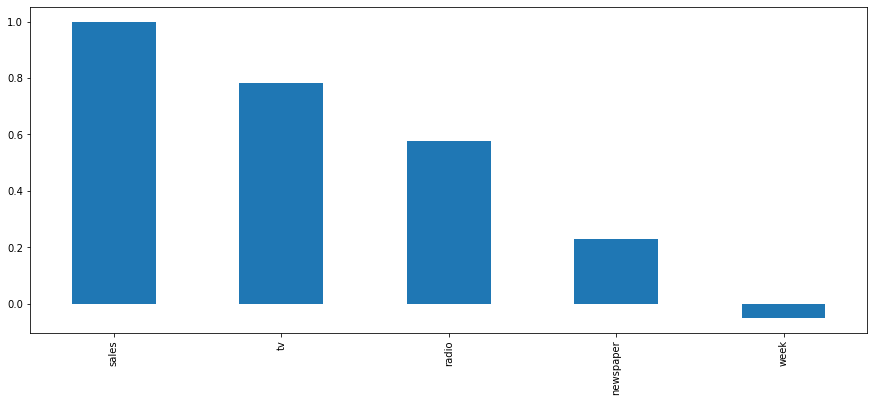

In [4]:
plt.figure(figsize=(15,6))
bars = df.corr()['sales'].sort_values(ascending=False).plot(kind='bar')

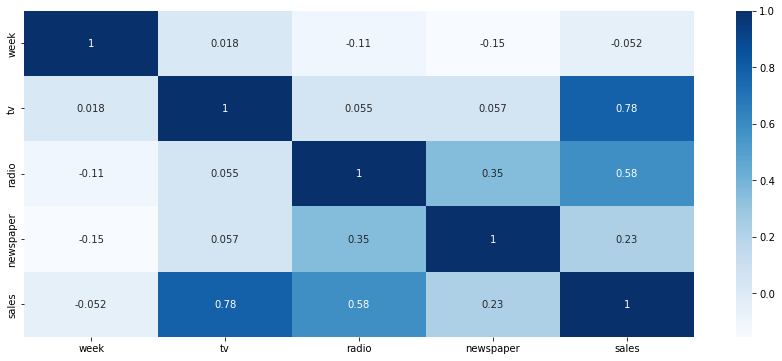

In [5]:
plt.figure(figsize=(15,6))
heatmap = sns.heatmap(df.corr(), annot=True, cmap="Blues")

## Create training and test data

In [6]:
X = df[['week', 'tv', 'radio', 'newspaper']]
y = df['sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [32]:
#Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
regressors = {
    "XGBRegressor": XGBRegressor(),
    "RandomForestRegressor": RandomForestRegressor(),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "GaussianProcessRegressor": GaussianProcessRegressor(),
    "SVR": SVR(),
    "NuSVR": NuSVR(),
    "LinearSVR": LinearSVR(),
    "KernelRidge": KernelRidge(),
    "LinearRegression": LinearRegression(),
    "Ridge":Ridge(),
    "Lars": Lars(),
    "TheilSenRegressor": TheilSenRegressor(),
    "HuberRegressor": HuberRegressor(),
    "PassiveAggressiveRegressor": PassiveAggressiveRegressor(),
    "ARDRegression": ARDRegression(),
    "BayesianRidge": BayesianRidge(),
    "ElasticNet": ElasticNet(),
    "OrthogonalMatchingPursuit": OrthogonalMatchingPursuit(),
}

In [9]:
df_models = pd.DataFrame(columns=['model', 'run_time', 'rmse', 'rmse_cv'])

for key in regressors:

    print('*',key)

    start_time = time.time()

    regressor = regressors[key]
    model = regressor.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    scores = cross_val_score(model, 
                             X_train, 
                             y_train,
                             scoring="neg_mean_squared_error", 
                             cv=10)

    row = {'model': key,
           'run_time': format(round((time.time() - start_time)/60,2)),
           'rmse': round(np.sqrt(mean_squared_error(y_test, y_pred))),
           'rmse_cv': round(np.mean(np.sqrt(-scores)))
    }

    df_models = df_models.append(row, ignore_index=True)

* XGBRegressor
* RandomForestRegressor
* DecisionTreeRegressor
* GaussianProcessRegressor
* SVR
* NuSVR
* LinearSVR
* KernelRidge
* LinearRegression
* Ridge
* Lars
* TheilSenRegressor
* HuberRegressor
* PassiveAggressiveRegressor
* ARDRegression
* BayesianRidge
* ElasticNet
* OrthogonalMatchingPursuit


In [10]:
df_models.head(20).sort_values(by='rmse_cv', ascending=True)

,model,run_time,rmse,rmse_cv
0,XGBRegressor,0.01,1,1
1,RandomForestRegressor,0.02,1,1
2,DecisionTreeRegressor,0.0,2,1
15,BayesianRidge,0.0,2,2
14,ARDRegression,0.0,2,2
13,PassiveAggressiveRegressor,0.0,2,2
12,HuberRegressor,0.0,2,2
11,TheilSenRegressor,0.07,2,2
10,Lars,0.0,2,2
8,LinearRegression,0.0,2,2


Our top 3 models are XGBRegressor, RandomForestRegressor, and DecisionTreeRegressor.


## Futher Improvement
To get better result for our prediction, we can take futher steps:
1. hyperparamter tunning
2. combined all the models into ensembled models
3. If there are avalible data, try to add features of Price, Product, Place, Promotion (important 4P of marketing activity)


In [19]:
from sklearn.ensemble import VotingRegressor

In [22]:
estimator=[]
RF=RandomForestRegressor()
XGB=XGBRegressor()
DT=DecisionTreeRegressor()
model= VotingRegressor([('RF', RF), ('XGB', XGB), ('DT', DT)])
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

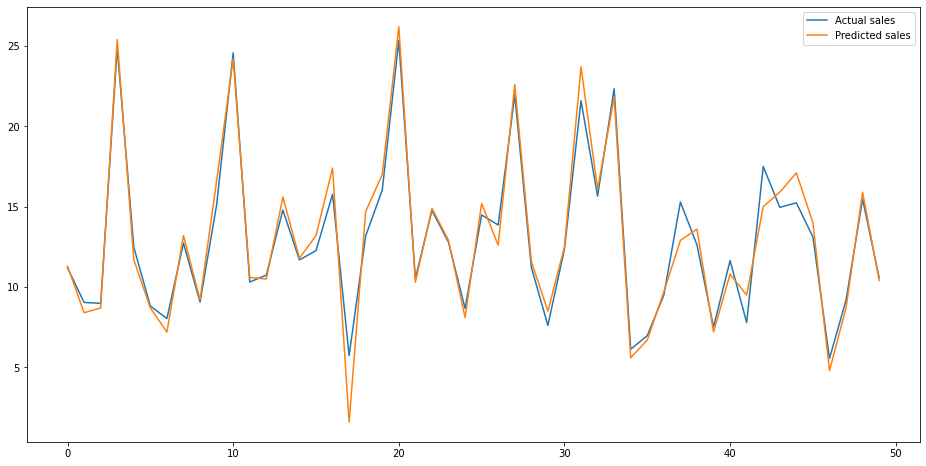

In [23]:
test = pd.DataFrame({'Predicted sales':y_pred, 'Actual sales':y_test})
fig= plt.figure(figsize=(16,8))
test = test.reset_index()
test = test.drop(['index'],axis=1)
plt.plot(test[:50])
plt.legend(['Actual sales','Predicted sales'])



## Implementation of the model
To study which combination of marketing investment would result in the highest return and lowerst cost, we can try to put in diffrent value of investment to the well-trained model to see what combination is financially feasible and cost efficicent to your marketing campaign.